In [174]:
#!pip install geopy

In [175]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import plotly.express as px
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree
from geopy.distance import geodesic

pd.set_option("display.max_rows", None, "display.max_columns", None)

# <center>Proyecto "Pump it Up: Data Mining the Water Table"<center>

David Echeverr√≠a

**Predicci√≥n del Estado de Bombas de Agua en Tanzania**

Este proyecto aborda el reto de predecir el estado operativo de las bombas de agua en Tanzania (codificado como funcional, necesita reparaci√≥n, no funcional), utilizando datos abiertos de DrivenData. Mejorar la eficiencia en el mantenimiento de estas bombas es crucial para garantizar el acceso al agua potable en zonas rurales.

Durante el desarrollo se identificaron desaf√≠os significativos:
- **Datos incompletos y registros inv√°lidos**: cerca del 40% de los registros presentaban valores nulos o inconsistentes en variables clave como `construction_year` y `gps_height`.
- **Variables categ√≥ricas de alta cardinalidad**: muchas variables conten√≠an decenas de categor√≠as, lo que complicaba su uso directo en modelos de machine learning.
- **Distribuci√≥n de clases desbalanceada**: predominancia de bombas funcionales frente a las que requieren mantenimiento.

Para resolverlos se implementaron:
- **Limpieza de datos**: eliminaci√≥n de outliers extremos y tratamiento de nulos sin imputaciones arbitrarias que pudieran sesgar los resultados.
- **Feature Engineering**: codificaci√≥n estrat√©gica de variables categ√≥ricas por grupos de cardinalidad, generaci√≥n de nuevas variables como la cantidad de bombas no funcionales en un radio de 10km y conversi√≥n de atributos temporales en variables num√©ricas relevantes.
- **Selecci√≥n de variables**: identificaci√≥n de los atributos m√°s predictivos para reducir ruido y mejorar el desempe√±o de los modelos.
- **Modelado y validaci√≥n**: uso de Random Forest con validaci√≥n estratificada y ajuste de hiperpar√°metros, optimizando la m√©trica F1-macro dada la naturaleza multiclase y el desbalance.

**Resultados**:
- El modelo alcanz√≥ un **F1-macro score de 0.8020**.
- Las variables con mayor importancia predictiva fueron `quantity`, `gps_height`, `longitude` y `population`.

Este modelo puede ser una herramienta efectiva para anticipar necesidades de mantenimiento y optimizar el uso de recursos en programas de abastecimiento de agua.

---

## 1) Data Acquisition & Understanding

### 1.1) Carga de datos y preparaci√≥n inicial

Para evitar confusiones renombramos los csv y cargamos.

In [183]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

Verificamos dimensiones

In [185]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (59400, 40)
X_test shape: (14850, 40)
y_train shape: (59400, 2)


Nos Aseg√∫ramos de que la columna id coincida entre `X_train` y `y_train`.

In [187]:
assert all(X_train['id'] == y_train['id']), "IDs no coinciden entre X_train y y_train"

A√±adimos la columna `status_group` a `X_train` para poder verificar relaciones de variables predictoras con la variable objetivo m√°s adelante.

In [189]:
X_train["status_group"] = y_train["status_group"]

Agregamos la columna `is_train` para poder diferenciar los registros al volver a separar los datos despu√©s del preprocesado.

In [191]:
X_train["is_train"] = True
X_test["is_train"] = False

Generamos una columna dummy en `X_test` para poder unir ambos datasets sin error (se eliminar√° antes del modelado final).

In [193]:
X_test["status_group"] = None

Generamos un dataFrame maestro con `X_train` y `X_test`

In [195]:
full_df = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

Guardamos una copia de ese dataFrame para trazabilidad en caso de necesitarse.

In [197]:
#full_df.to_csv("X_full_dirty.csv", index=False)

Verificamos el head del dataFrame maestro `full_df` y su shape que debe tener 74250 registros.

In [199]:
full_df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe multiple    communal standpipe   
3  groundwater  communal standpipe multiple    communal standp

In [200]:
full_df.shape

(74250, 42)

---

### 1.2) EDA

#### Verificamos que el tipo de variables sea el correcto

Hacemos un chequeo general y parece que las variables se cargaron con tipos coherentes.

In [205]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

Verificamos que las variables categ√≥ricas se cargaron como tipo `object`. 

Un caso especial es `date_recorded` que debe ser cambiada de tipo. Es importante anotar que para que sea una variable que se aproveche en un modelo debe ser transformada en el proceso de feature engineering, esto de acuerdo al modelo que se va a entrenar. Por ejemplo, para Random Forest se requiere que se extraigan componentes como mes, semana, d√≠a, etc.

In [207]:
full_df.select_dtypes('object').head()

date_recorded        funder     installer              wpt_name  \
0    2011-03-14         Roman         Roman                  none   
1    2013-03-06       Grumeti       GRUMETI              Zahanati   
2    2013-02-25  Lottery Club  World vision           Kwa Mahundi   
3    2013-01-28        Unicef        UNICEF  Zahanati Ya Nanyumbu   
4    2011-07-13   Action In A       Artisan               Shuleni   

                     basin  subvillage   region        lga        ward  \
0               Lake Nyasa    Mnyusi B   Iringa     Ludewa    Mundindi   
1            Lake Victoria     Nyamara     Mara  Serengeti       Natta   
2                  Pangani     Majengo  Manyara  Simanjiro     Ngorika   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara   Nanyumbu    Nanyumbu   
4            Lake Victoria  Kyanyamisa   Kagera    Karagwe  Nyakasimbi   

  public_meeting              recorded_by scheme_management  \
0           True  GeoData Consultants Ltd               VWC   
1            NaN  GeoData Consultants Ltd             Other   
2           True  GeoData Consultants Ltd               VWC   
3           True  GeoData Consultants Ltd               VWC   
4           True  GeoData Consultants Ltd               NaN   

                   scheme_name permit extraction_type extraction_type_group  \
0                        Roman  False         gravity               gravity   
1                          NaN   True         gravity               gravity   
2  Nyumba ya mungu pipe scheme   True         gravity               gravity   
3                          NaN   True     submersible           submersible   
4                          NaN   True         gravity               gravity   

  extraction_type_class management management_group         payment  \
0               gravity        vwc       user-group    pay annually   
1               gravity        wug       user-group       never pay   
2               gravity        vwc       user-group  pay per bucket   
3           submersible        vwc       user-group       never pay   
4               gravity      other            other       never pay   

  payment_type water_quality quality_group      quantity quantity_group  \
0     annually          soft          good        enough         enough   
1    never pay          soft          good  insufficient   insufficient   
2   per bucket          soft          good        enough         enough   
3    never pay          soft          good           dry            dry   
4    never pay          soft          good      seasonal       seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    communal standpipe  non functional  
4           communal standpipe    communal standpipe      functional

Al analizar las variables restantes notamos que casi todos los tipos estan bien cargados. La excepci√≥n son:
- La variable `id`, que se excluye de todo modelo porque no aporta informaci√≥n.
- Las viariables `gps_height`, `longitude`, `latitude`. Dichas variables deben ser procesadas para ser aprovechadas como datos geogr√°ficos, cosa que queda pendiente para el feature engineering.
- `region_code` y `district_code` deber√≠an ser categ√≥ricas ya que hacen referencia a zonas geogr√°ficas.
- `num_private` no se sabe que es, se debe ver si tiene varianza y chequear que valores muestra, asi como la distribucion para tratar de inferir su significaci√≥n.

In [209]:
full_df.select_dtypes(exclude='object').head()

id  amount_tsh  gps_height  longitude   latitude  num_private  \
0  69572      6000.0        1390  34.938093  -9.856322            0   
1   8776         0.0        1399  34.698766  -2.147466            0   
2  34310        25.0         686  37.460664  -3.821329            0   
3  67743         0.0         263  38.486161 -11.155298            0   
4  19728         0.0           0  31.130847  -1.825359            0   

   region_code  district_code  population  construction_year  is_train  
0           11              5         109               1999      True  
1           20              2         280               2010      True  
2           21              4         250               2009      True  
3           90             63          58               1986      True  
4           18              1           0                  0      True

---

#### Tipificamos correctamente las variables

Se tipifica la variable `date_recorded` como fecha y se verifica que se haya hecho el cambio

In [213]:
full_df['date_recorded'] = pd.to_datetime(full_df['date_recorded'])
full_df.select_dtypes('datetime').head()

date_recorded
0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13

Transformamos `region_code` y `district_code` a tipo `category`

In [215]:
full_df['region_code'] = full_df['region_code'].astype('category')
full_df['district_code'] = full_df['district_code'].astype('category')
full_df.select_dtypes('category').head()

region_code district_code
0          11             5
1          20             2
2          21             4
3          90            63
4          18             1

Transformamos todas las categ√≥ricas al tipo `category`

In [217]:
cols_objeto = full_df.select_dtypes(include='object').columns
full_df[cols_objeto] = full_df[cols_objeto].astype('category')
full_df.select_dtypes('category').head()

funder     installer              wpt_name                    basin  \
0         Roman         Roman                  none               Lake Nyasa   
1       Grumeti       GRUMETI              Zahanati            Lake Victoria   
2  Lottery Club  World vision           Kwa Mahundi                  Pangani   
3        Unicef        UNICEF  Zahanati Ya Nanyumbu  Ruvuma / Southern Coast   
4   Action In A       Artisan               Shuleni            Lake Victoria   

   subvillage   region region_code district_code        lga        ward  \
0    Mnyusi B   Iringa          11             5     Ludewa    Mundindi   
1     Nyamara     Mara          20             2  Serengeti       Natta   
2     Majengo  Manyara          21             4  Simanjiro     Ngorika   
3  Mahakamani   Mtwara          90            63   Nanyumbu    Nanyumbu   
4  Kyanyamisa   Kagera          18             1    Karagwe  Nyakasimbi   

  public_meeting              recorded_by scheme_management  \
0           True  GeoData Consultants Ltd               VWC   
1            NaN  GeoData Consultants Ltd             Other   
2           True  GeoData Consultants Ltd               VWC   
3           True  GeoData Consultants Ltd               VWC   
4           True  GeoData Consultants Ltd               NaN   

                   scheme_name permit extraction_type extraction_type_group  \
0                        Roman  False         gravity               gravity   
1                          NaN   True         gravity               gravity   
2  Nyumba ya mungu pipe scheme   True         gravity               gravity   
3                          NaN   True     submersible           submersible   
4                          NaN   True         gravity               gravity   

  extraction_type_class management management_group         payment  \
0               gravity        vwc       user-group    pay annually   
1               gravity        wug       user-group       never pay   
2               gravity        vwc       user-group  pay per bucket   
3           submersible        vwc       user-group       never pay   
4               gravity      other            other       never pay   

  payment_type water_quality quality_group      quantity quantity_group  \
0     annually          soft          good        enough         enough   
1    never pay          soft          good  insufficient   insufficient   
2   per bucket          soft          good        enough         enough   
3    never pay          soft          good           dry            dry   
4    never pay          soft          good      seasonal       seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    communal standpipe  non functional  
4           communal standpipe    communal standpipe      functional

Convertimos `id` a object para diferenciarla de todas las dem√°s variables y verificamos

In [219]:
full_df['id'] = full_df['id'].astype('object')
full_df.select_dtypes('object').head()

id
0  69572
1   8776
2  34310
3  67743
4  19728

Con eso el dataFrame queda tipificado correctamente. Queda pendiente verificar la variable `num_private` que no se sabe qu√© es, cosa que se determinar√° en posteriores an√°lisis gr√°ficos y descriptivos. Para finalizar verificamos como queda el dataFrame

In [221]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  object        
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 69743 non-null  category      
 4   gps_height             74250 non-null  int64         
 5   installer              69718 non-null  category      
 6   longitude              74250 non-null  float64       
 7   latitude               74250 non-null  float64       
 8   wpt_name               74248 non-null  category      
 9   num_private            74250 non-null  int64         
 10  basin                  74250 non-null  category      
 11  subvillage             73780 non-null  category      
 12  region                 74250 non-null  category      
 13  r

---

#### An√°lisis descriptivo General de variables num√©ricas

Al analizar las variables num√©ricas vemos lo siguiente:

`amount_tsh`  
Problema: m√°s del 50% de los pozos tienen 0 en esta variable.  
Conclusi√≥n: Los valores 0 probablemente representa un missing no declarado.  

`gps_height`  
Problema: el valor m√≠nimo es -90 y el 25% de los valores son 0, lo que indica valores imposibles o desconocidos.  
Conclusi√≥n: hay muchos valores dudosos o faltantes codificados como 0 o negativos.

`longitude`  
Problema: el m√≠nimo es 0, claramente inv√°lido (las longitudes v√°lidas para Tanzania est√°n entre 29 y 41).  
Conclusi√≥n: Todo lo que no este en el rango es un missing no declarado.

`latitude`  
Problema: los valores v√°lidos deber√≠an estar entre -12 y -1 en Tanzania.  
Conclusi√≥n: Todo lo que no este en el rango es un missing no declarado.

`num_private`  
Problema: media muy baja (`0.46`), pero con un valor m√°ximo de `1776`. El 98% de los valores son 0.  
Conclusi√≥n: probablemente es una variable irrelevante o mal documentada.

`population`  
Problema: casi el 50% de los pozos tienen 0 de poblaci√≥n, pero hay un m√°ximo de `30,500`, lo que sugiere outliers severos.  
Conclusi√≥n:  
- Muchos 0 pueden representar missing no declarados o pozos sin poblaci√≥n registrada.  
- Existen valores extremos que deben tratarse.  


`construction_year`  
Problema: cerca del 50% de los registros tienen el valor 0, que no es un a√±o v√°lido.  
Conclusi√≥n: el valor 0 representa un missing no declarado. El resto de los valores parece estar en un rango razonable (`1960‚Äì2013`).


In [225]:
full_df.describe()

amount_tsh                  date_recorded    gps_height  \
count   74250.000000                          74250  74250.000000   
mean      318.685704  2012-03-28 09:51:49.527272704    665.667313   
min         0.000000            2001-03-26 00:00:00    -90.000000   
25%         0.000000            2011-04-01 00:00:00      0.000000   
50%         0.000000            2012-10-10 00:00:00    364.000000   
75%        20.000000            2013-02-09 00:00:00   1317.000000   
max    350000.000000            2013-12-03 00:00:00   2777.000000   
std      2906.762364                            NaN    692.761033   

          longitude      latitude   num_private    population  \
count  74250.000000  7.425000e+04  74250.000000  74250.000000   
mean      34.074262 -5.701771e+00      0.462330    180.750828   
min        0.000000 -1.164944e+01      0.000000      0.000000   
25%       33.086819 -8.525675e+00      0.000000      0.000000   
50%       34.907475 -5.026540e+00      0.000000     25.000000   
75%       37.181685 -3.325058e+00      0.000000    215.000000   
max       40.345193 -2.000000e-08   1776.000000  30500.000000   
std        6.572519  2.944969e+00     11.537879    471.086120   

       construction_year  
count       74250.000000  
mean         1298.463650  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000  
std           952.349375

---

Los missings no declarados en variables num√©ricas son valores mal codificados o fuera de rangos esperados determinados por el dominio

In [228]:
# Funciones que usaremos en esta secci√≥n
def histogram_boxplot(data, xlabel=None, title=None, font_scale=2, figsize=(9,8), bins=None):
    """ 
    Boxplot and histogram combined
    
    Par√°metros:
    - data: Serie o array de una dimensi√≥n con datos num√©ricos
    - xlabel: etiqueta del eje x (opcional)
    - title: t√≠tulo del gr√°fico (opcional)
    - font_scale: escala de fuente para etiquetas (default = 2)
    - figsize: tama√±o de la figura (default = (9,8))
    - bins: n√∫mero de bins para el histograma (default = None / autom√°tico)

    Notas:
    - Dibuja media (l√≠nea verde) y mediana (l√≠nea amarilla) en el histograma.
    - Elimina valores nulos antes de graficar.
    """
    # Definir tama√±o de letra
    sns.set(font_scale=font_scale)
    
    # Eliminar nulos para evitar errores
    data = data.dropna()
    
    # Crear ventana para los subgr√°ficos
    f2, (ax_box2, ax_hist2) = plt.subplots(
        2, sharex=True, 
        gridspec_kw={"height_ratios": (.15, .85)}, 
        figsize=figsize
    )
    
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)

    # Crear histograma (condicional robusto para evitar error de bins=None)
    if bins is not None:
        sns.histplot(x=data, ax=ax_hist2, bins=bins)
    else:
        sns.histplot(x=data, ax=ax_hist2)
    
    # Pintar l√≠neas de media y mediana
    ax_hist2.axvline(np.mean(data), color='g', linestyle='-', label='Media')
    ax_hist2.axvline(np.median(data), color='y', linestyle='--', label='Mediana')
    ax_hist2.legend()

    # Asignar etiquetas
    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title, xlabel="")

    # Ajustar y mostrar
    plt.tight_layout()
    plt.show()
    plt.close()

def cat_plot(col):
    '''
    Genera un gr√°fico de barras (countplot) para una variable categ√≥rica.
    
    Par√°metros:
    - col: Serie categ√≥rica (pandas.Series) que se desea graficar.

    Notas:
    - Las categor√≠as se ordenan de mayor a menor frecuencia.
    - Se eliminan valores nulos antes de graficar.
    '''
    col = col.dropna()
    name = col.name or "Variable categ√≥rica"
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, order=col.value_counts().index, palette="pastel")
    plt.title(f"Distribuci√≥n de frecuencias de {name}")
    plt.xlabel(name)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot(col):
    '''
    Determina si una variable es num√©rica o categ√≥rica y grafica su distribuci√≥n 
    usando el tipo de gr√°fico correspondiente.

    Par√°metros:
    - col: Serie de pandas (categ√≥rica o num√©rica).

    Notas:
    - Si es tipo `category`, llama a `cat_plot()`.
    - Si es tipo `int64` o `float64`, llama a `histogram_boxplot()`.
    - Variables tipo `object` o `bool` no son graficadas por esta funci√≥n.
    '''
    if col.dtype.name == 'category':
        cat_plot(col)
    elif col.dtype in ['int64', 'float64']:
        histogram_boxplot(col, xlabel=col.name, title=f"Distribuci√≥n de {col.name}")

In [229]:
def gestiona_outliers(col, clas='check'):
    '''
    Gestiona outliers en una columna num√©rica utilizando dos criterios estad√≠sticos:
    - Criterio 1: z-score si la variable es sim√©trica, o MAD si es asim√©trica.
    - Criterio 2: m√©todo del rango intercuart√≠lico extendido (IQR * 3).

    Par√°metros:
    - col: pandas.Series con datos num√©ricos.
    - clas: str, modo de operaci√≥n:
        - 'check': devuelve las proporciones de outliers por debajo, por encima y total (en %).
        - 'winsor': devuelve la serie winsorizada seg√∫n las proporciones detectadas.
        - 'miss': reemplaza los outliers por NaN y devuelve la serie modificada.

    Retorna:
    - Si clas == 'check': tupla con (porcentaje_inferiores, porcentaje_superiores, porcentaje_total).
    - Si clas == 'winsor': serie con winsorizaci√≥n aplicada.
    - Si clas == 'miss': serie con outliers reemplazados por NaN.
    '''
    print(col.name)

    # Criterio 1: adaptativo seg√∫n simetr√≠a
    if abs(col.skew()) < 1:
        criterio1 = abs((col - col.mean()) / col.std()) > 3
    else:
        mad = (col - col.median()).abs().median()
        criterio1 = abs((col - col.median()) / mad) > 8 if mad != 0 else pd.Series(False, index=col.index)

    # Criterio 2: IQR extendido
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    IQR = q3 - q1
    criterio2 = (col < (q1 - 3 * IQR)) | (col > (q3 + 3 * IQR))

    # C√°lculo de proporciones
    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.dropna().count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.dropna().count()

    # Salidas seg√∫n el modo seleccionado
    if clas == 'check':
        return (lower * 100, upper * 100, (lower + upper) * 100)
    
    elif clas == 'winsor':
        return winsorize_with_pandas(col, (lower, upper))
    
    elif clas == 'miss':
        print('\nMissingAntes:', col.isna().sum())
        col.loc[criterio1 & criterio2] = np.nan
        print('MissingDespues:', col.isna().sum(), '\n')
        return col



def winsorize_with_pandas(s, limits):
    '''
    Aplica winsorizaci√≥n a una serie de pandas, limitando los valores extremos
    seg√∫n los percentiles especificados.

    Par√°metros:
    - s: pandas.Series
        Serie num√©rica a la que se le aplicar√° la winsorizaci√≥n.
    - limits: tuple(float, float)
        Tupla con los l√≠mites inferiores y superiores a recortar, expresados como proporciones 
        entre 0 y 1. Por ejemplo, (0.05, 0.05) recorta el 5% inferior y el 5% superior.

    Retorna:
    - pandas.Series con los valores extremos recortados a los percentiles correspondientes.
    '''
    return s.clip(
        lower=s.quantile(limits[0], interpolation='lower'),
        upper=s.quantile(1 - limits[1], interpolation='higher')
    )


1. `amount_tsh`

Hip√≥tesis: Los valores 0 probablemente representa un missing no declarado.


Vemos que hay muchos ceros, cerca del 70% de ceros

In [232]:
plot(full_df['amount_tsh'])

![](../outputs/distribucion_amount_tsh_original.png)

In [234]:
# Proporci√≥n de ceros
proporcion_ceros = (full_df['amount_tsh'] == 0).mean()
print(f" Proporci√≥n de ceros de amount_tsh: {proporcion_ceros:.2%}")

 Proporci√≥n de ceros de amount_tsh: 70.10%


Analizando la relaci√≥n de `amount_tsh` con la variable objetivo vemos que los ceros no tienen un comportamiento espec√≠fico frente a la variable objetivo, pero si se filtran los `0` de `amount_tsh` podria ser relevante, dados los porcentajes generales de las categorias de la variable objetivo. 

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



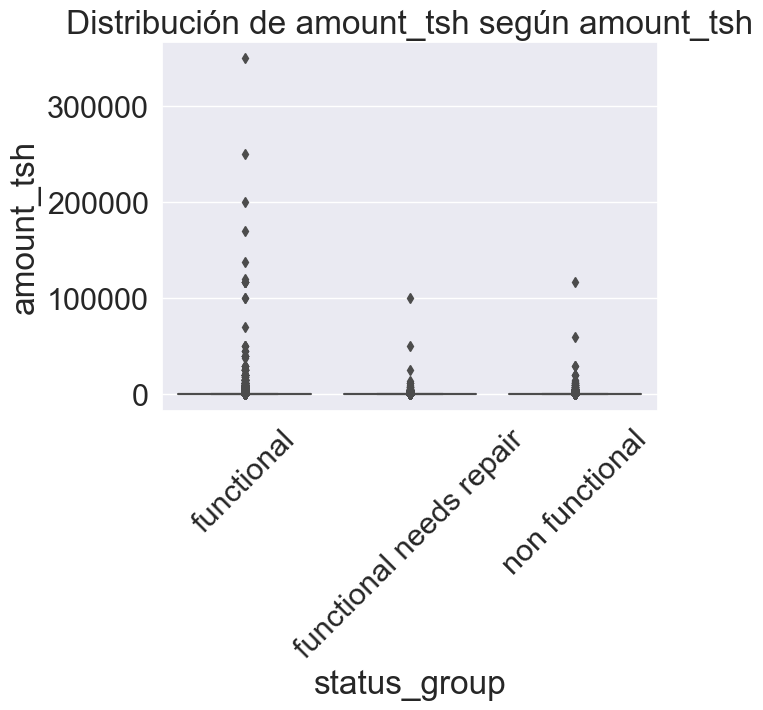

In [236]:
sns.boxplot(x='status_group', y='amount_tsh', data=full_df)
plt.xticks(rotation=45)
plt.title("Distribuci√≥n de amount_tsh seg√∫n amount_tsh")
plt.show()

In [237]:
# Filtrar solo registros donde amount_tsh == 0
subset = full_df[full_df['amount_tsh'] == 0]

# Contar cu√°ntos ceros hay por categor√≠a de status_group
print('ceros hay por categor√≠a de status_group donde amount_tsh == 0')
subset['status_group'].value_counts(normalize= True).sort_index()

ceros hay por categor√≠a de status_group donde amount_tsh == 0


status_group
functional                 0.473258
functional needs repair    0.073201
non functional             0.453541
Name: proportion, dtype: float64

In [238]:
# Filtrar solo registros donde amount_tsh > 0
subset = full_df[full_df['amount_tsh'] > 0]

# Contar cu√°ntos ceros hay por categor√≠a de status_group
print('ceros hay por categor√≠a de status_group donde amount_tsh > 0')
subset['status_group'].value_counts(normalize= True).sort_index()

ceros hay por categor√≠a de status_group donde amount_tsh > 0


status_group
functional                 0.706773
functional needs repair    0.071449
non functional             0.221778
Name: proportion, dtype: float64

In [239]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

Si quitamos los missing no declarados el porcentaje de outliers es de 6%

In [241]:
# Evaluar la proporci√≥n de outliers sin modificar el DataFrame
columna = full_df['amount_tsh'][full_df['amount_tsh'] > 0].copy()
porc_inf, porc_sup, porc_total = gestiona_outliers(columna, clas='check')

# Mostrar resultados
print(f"Proporci√≥n de outliers por debajo: {porc_inf:.2f}%")
print(f"Proporci√≥n de outliers por encima: {porc_sup:.2f}%")
print(f"Proporci√≥n total de outliers: {porc_total:.2f}%")

amount_tsh
Proporci√≥n de outliers por debajo: 0.00%
Proporci√≥n de outliers por encima: 6.24%
Proporci√≥n total de outliers: 6.24%


Conclusiones de `amount_tsh`:
- Eliminar outliers y registros inv√°lidos
    - Modelo Actual:
        - Reemplazar los 0 por `NaN` porque se comportan de manera indeterminada con respecto a la variable objetivo.
        - Winsorizar outliers
        - Ver si vale la pena mantener debido al porcentaje de valores NaN
        - Imputar con la mediana por distrito (district_code) o por region, para conservar patrones territoriales

    - Modelos Futuros:
        - Convertir outliers a missing
        - Imputar con la mediana por distrito (district_code) o por region, para conservar patrones territoriales


- Feature Engineering:
    - Modelos Futuros:
        - Crea una variable booleana, una suerte de binning, en base a la variable original, auxiliar que agrupe `0` y `!= 0`.
        - Aplicar una transformaci√≥n `log(1 + x)` para estabilizar la distribuci√≥n de la variable original ()

---

2. `gps_height`
Hip√≥tesis: hay muchos valores dudosos o faltantes codificados como 0 o negativos.

Confirmamos que existen muchos `0` y valores fuera del rango posible `<0`

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



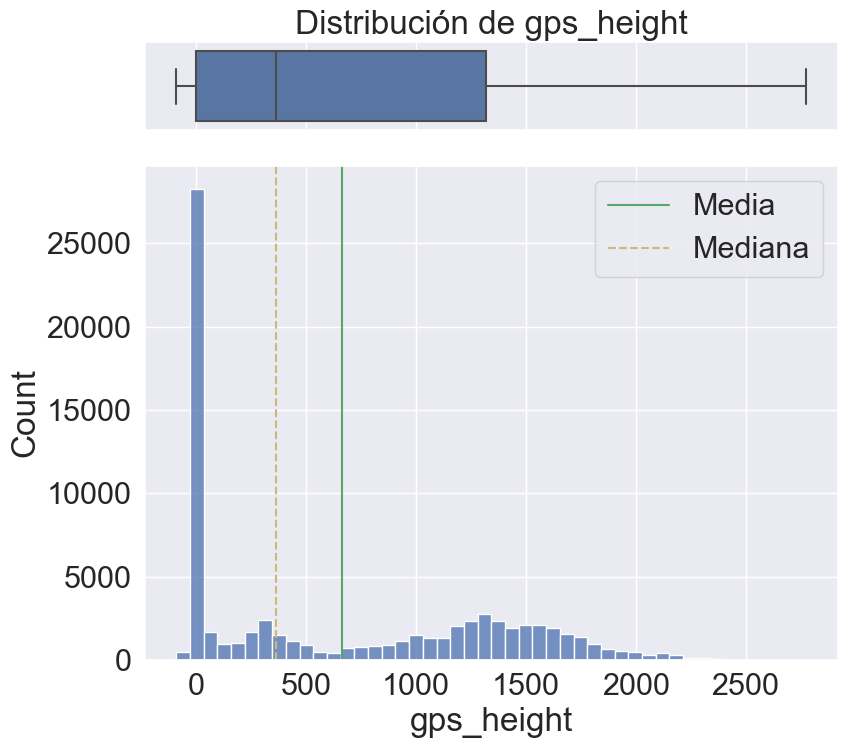

In [246]:
plot(full_df['gps_height'])

In [247]:
# Proporci√≥n valores <0
proporcion_ceros = (full_df['gps_height'] <= 0).mean()
print(f" Proporci√≥n de valores <= 0 de gps_height: {proporcion_ceros:.2%}")

 Proporci√≥n de valores <= 0 de gps_height: 37.08%


Vemos si estos valores imposibles tienen alg√∫n valor de predicci√≥n. Y vemos que parece que no por lo que podriamos convertirlos a NaN sin otras acciones posteriores

In [249]:
# Filtrar solo registros donde gps_height <= 0
subset = full_df[full_df['gps_height'] <= 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de gps_height
print('valores por categor√≠a de status_group donde gps_height <= 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde gps_height <= 0


status_group
functional                 0.512948
functional needs repair    0.082292
non functional             0.404760
Name: proportion, dtype: float64

Vemos el valor predictivo de los valores restantes con respecto a la variable objetivo y parece que es bueno.

In [251]:
# Filtrar solo registros donde gps_height > 0
subset = full_df[full_df['gps_height'] > 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de gps_height
print('valores por categor√≠a de status_group donde gps_height > 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde gps_height > 0


status_group
functional                 0.560722
functional needs repair    0.067047
non functional             0.372231
Name: proportion, dtype: float64

Contextualizamos con los porcentajes generales de la variable objetivo y vemos que el aporte no es muy alto, los porcentajes casi no varian, pero podr√≠a servir.

In [253]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

Conclusiones de `gps_height`:

- Eliminaci√≥n outliers y registros inv√°lidos
    - Modelo Actual:
        - Tratar `gps_height <= 0` como missing no declarado.
        - Winsorizar outliers, aunque parece que no existen. 
        - Imputar con la mediana por distrito (district_code) o por region, para conservar patrones territoriales
    - Modelos Futuros:
        - Convertir outliers a missing
        - Imputar con la mediana por distrito (district_code) o por region, para conservar patrones territoriales
- Feature Engineering:
    - Modelos Futuros: 
        - Aplicar una transformaci√≥n `log(1 + x)` para estabilizar la distribuci√≥n de la variable original ()

---

3. `longitude`  
Hip√≥tesis: Todo lo que no este en el rango es un missing no declarado  

Analizando la distribuci√≥n, vemos que no hay muchos valores inv√°lidos (fuera de rango tomando en cuenta los valores posibles de Tanzania), solo el 3%

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



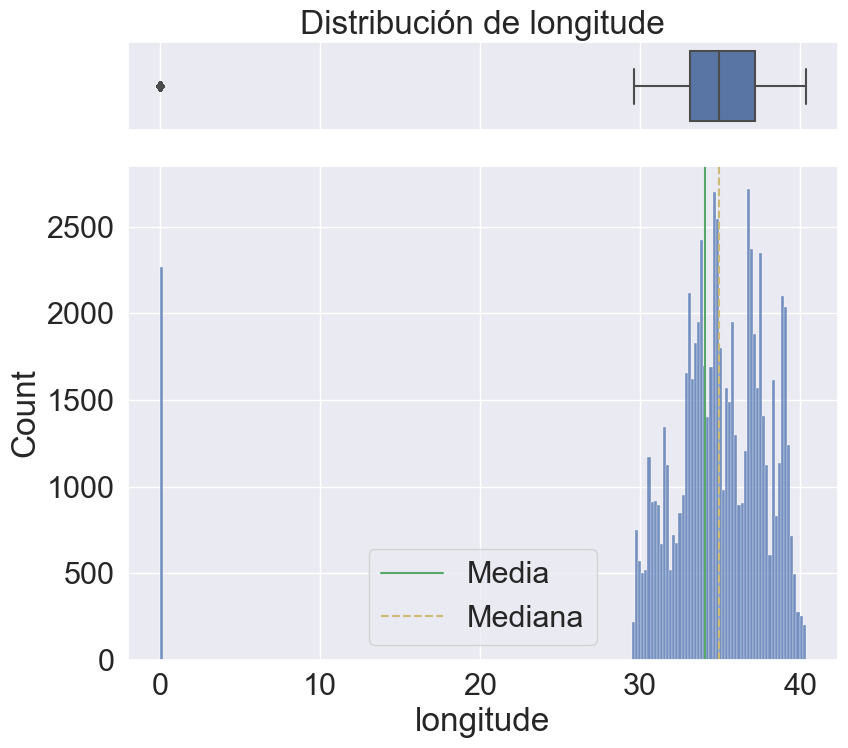

In [258]:
plot(full_df['longitude'])

In [259]:
# Proporci√≥n valores no v√°lidos fuera del rango [29, 41]
proporcion_invalidos = ((full_df['longitude'] < 29.20) | (full_df['longitude'] > 40.45)).mean()
print(f"Proporci√≥n de valores fuera del rango en longitude: {proporcion_invalidos:.2%}")

Proporci√≥n de valores fuera del rango en longitude: 3.06%


Vemos que los datos validos parecen no tener un poder predictivo real a primera vista, pero los datos inv√°lidos s√≠ parecen estar relacionados a la categor√≠a `functional needs repair` de la varieble objetivo

In [261]:
# Filtrar registros con valores de longitude v√°lidos para Tanzania
subset = full_df[(full_df['longitude'] > 29.20) | (full_df['longitude'] < 40.45)]

# Mostrar proporciones de status_group en ese subconjunto
print("Distribuci√≥n de status_group en registros con longitude dentro del rango [29.20, 40.45]:")
print(subset['status_group'].value_counts(normalize=True).sort_index())

Distribuci√≥n de status_group en registros con longitude dentro del rango [29.20, 40.45]:
status_group
functional                 0.543081
functional needs repair    0.072677
non functional             0.384242
Name: proportion, dtype: float64


In [262]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [263]:
# Filtrar registros con valores de longitude fuera del rango v√°lido para Tanzania
subset = full_df[(full_df['longitude'] < 29.20) | (full_df['longitude'] > 40.45)]

# Mostrar proporciones de status_group en ese subconjunto
print("Distribuci√≥n de status_group en registros con longitude fuera del rango [29.20, 40.45]:")
print(subset['status_group'].value_counts(normalize=True).sort_index())

Distribuci√≥n de status_group en registros con longitude fuera del rango [29.20, 40.45]:
status_group
functional                 0.480132
functional needs repair    0.213024
non functional             0.306843
Name: proportion, dtype: float64


Conclusiones:

- Eliminaci√≥n de outliers y registros inv√°lidos
    - Modelo Actual:
        - Filtrar registros v√°lidos dentro del rango [29.20, 40.45] (basado en coordenadas reales de Tanzania).
        - Reemplazar valores fuera de ese rango por NaN, ya que los modelos basados en √°rboles pueden manejar NaN directamente.
        - Crear la variable booleana `coord_invalida` que marque coordenadas inv√°lidas, para preservar su poder predictivo, especialmente en la clase functional needs repair.
        - Los outliers podrian ser winsorizados aunque no parecen existir.

    - Modelos Futuros:
        - Si se usan modelos que no aceptan NaN, imputar los valores inv√°lidos con un valor simb√≥lico fuera de rango (por ejemplo, -999), asegur√°ndose de mantener el flag `coord_invalida`.
        - Evaluar la conveniencia de eliminar longitude si se sustituye por transformaciones espaciales m√°s robustas (como clusters o distancias geogr√°ficas).

- Feature Engineering
    - Modelo Actual:
        - Crear una variable indicadora (coord_invalida) para conservar la se√±al de error en coordenadas.
        - Generar clusters espaciales (geo_cluster) con K-Means o DBSCAN usando solo registros v√°lidos (verificados con `coord_invalida`).
        - Calcular distancias a puntos clave (por ejemplo, la capital), excluyendo coordenadas inv√°lidas.
        - Calcular n√∫mero o proporci√≥n de vecinos no funcionales (con BallTree), excluyendo valores no v√°lidos.

    - Modelos Futuros:
        - Evaluar la utilidad de longitude y latitude como variables crudas en combinaci√≥n con el flag y las variables derivadas.
        - Si se usan embeddings espaciales o redes neuronales con coordenadas, normalizar e imputar expl√≠citamente los NaN con categor√≠as especiales.
        - Incluir una categor√≠a artificial (geo_cluster = -1) para registros con coordenadas inv√°lidas, si se usa clustering.

---

4. `latitude`  
Hip√≥tesis: Todo lo que no este en el rango es un missing no declarado 
Recomendaci√≥n:  
- Filtrar registros dentro del rango `[-12, -1]`.  
- Tratar el valor `-2e-08` como `NaN`.
- Si los registros inv√°lidos son pocos y solo est√°n en `X_train`, considerar eliminarlos.  
- Alternativamente, imputar con la media/mediana del distrito (`district_code`) u otra variable geogr√°fica relevante.  
- Tambi√©n es posible imputar con el centroide de un cluster espacial.

Analizando la distribuci√≥n, vemos que no hay muchos valores inv√°lidos (fuera de rango tomando en cuenta los valores posibles de Tanzania), solo el 3%. Es notable que el porcentaje es exactamente el mismo que el de longitude, asi que puede ser que los registros perdidos coincidan en las dos variables.

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



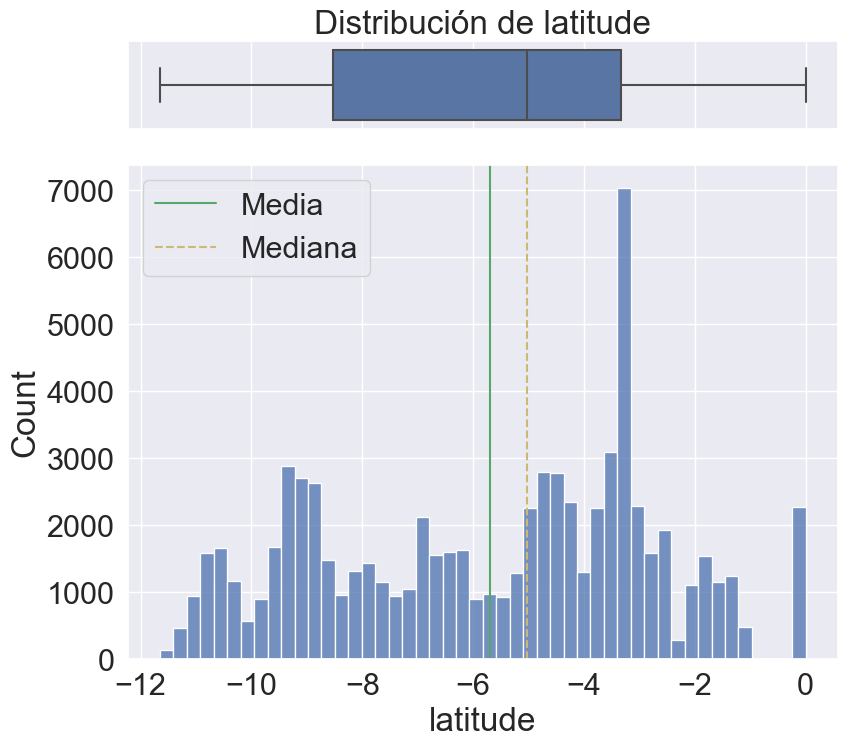

In [268]:
plot(full_df['latitude'])

In [269]:
# Proporci√≥n valores no v√°lidos fuera del rango [29, 41]
proporcion_invalidos = ((full_df['latitude'] < -11.75) | (full_df['latitude'] > -0.98)).mean()
print(f"Proporci√≥n de valores fuera del rango en latitude: {proporcion_invalidos:.2%}")

Proporci√≥n de valores fuera del rango en latitude: 3.06%


Vemos que si bien los valores correctos de la variable no parecen tener un poder predictivo al contrastarlos con las proporciones de valores de `status_group` en todo el data set, los valores perdidos parecen tener poder predictivo, al igual que latitude para la categor√≠a `functional needs repair`.

In [271]:
# Filtrar registros con valores de latitude v√°lidos para Tanzania
subset = full_df[(full_df['latitude'] >= -11.75) & (full_df['latitude'] <= -0.98)]

# Mostrar proporciones de status_group en ese subconjunto
print("Distribuci√≥n de status_group en registros con latitude dentro del rango [-11.75, -0.98]:")
print(subset['status_group'].value_counts(normalize=True).sort_index())

Distribuci√≥n de status_group en registros con latitude dentro del rango [-11.75, -0.98]:
status_group
functional                 0.545061
functional needs repair    0.068261
non functional             0.386678
Name: proportion, dtype: float64


In [272]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [273]:
# Filtrar registros con valores de latitude fuera del rango v√°lido para Tanzania
subset = full_df[(full_df['latitude'] < -11.75) | (full_df['latitude'] > -0.98)]

# Mostrar proporciones de status_group en ese subconjunto
print("Distribuci√≥n de status_group en registros con latitude fuera del rango [-11.75, -0.98]:")
print(subset['status_group'].value_counts(normalize=True).sort_index())

Distribuci√≥n de status_group en registros con latitude fuera del rango [-11.75, -0.98]:
status_group
functional                 0.480132
functional needs repair    0.213024
non functional             0.306843
Name: proportion, dtype: float64


Conclusiones de`latitude`  

- Eliminaci√≥n de outliers y registros inv√°lidos
    - Modelo Actual:
        - Filtrar registros v√°lidos dentro del rango geogr√°fico estimado de Tanzania [-11.75, -0.98] y reemplazar los valores fuera de rango por NaN, dado que los modelos basados en √°rboles pueden trabajar con ellos directamente.
        - Crear una variable booleana coord_invalida para identificar coordenadas inv√°lidas. Esto es importante porque el 3.06% de registros est√° fuera de rango (igual que en longitude), lo que sugiere coincidencia de registros con coordenadas perdidas ya que los valores inv√°lidos presentan una distribuci√≥n distinta de la variable objetivo, con una mayor proporci√≥n de la clase functional needs repair.
        - No imputamos ya que Random Forest funciona con NaN
    - Modelos Siguientes:
        - Si se usan modelos que no aceptan NaN, imputar los valores inv√°lidos con un valor simb√≥lico fuera de rango (por ejemplo, -999), asegur√°ndose de mantener el flag coord_invalida.
        - Evaluar la conveniencia de eliminar longitude si se sustituye por transformaciones espaciales m√°s robustas (como clusters o distancias geogr√°ficas).

- Feature Engineering
    - Modelo Actual:
        - Crear una variable indicadora (coord_invalida) para conservar la se√±al de error en coordenadas.
        - Generar clusters espaciales (geo_cluster) con K-Means o DBSCAN usando solo registros v√°lidos (verificados con `coord_invalida`).
        - Calcular distancias a puntos clave (por ejemplo, la capital), excluyendo coordenadas inv√°lidas.
        - Calcular n√∫mero o proporci√≥n de vecinos no funcionales (con BallTree), excluyendo valores no v√°lidos.

    - Modelos Futuros:
        - Evaluar la utilidad de longitude y latitude como variables crudas en combinaci√≥n con el flag y las variables derivadas.
        - Si se usan embeddings espaciales o redes neuronales con coordenadas, normalizar e imputar expl√≠citamente los NaN con categor√≠as especiales.
        - Incluir una categor√≠a artificial (geo_cluster = -1) para registros con coordenadas inv√°lidas, si se usa clustering.

---

5. `num_private`  
Hip√≥tesis: probablemente es una variable irrelevante o mal documentada.  

la variable `num-private`, esta llena de 0 en casi 99%

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



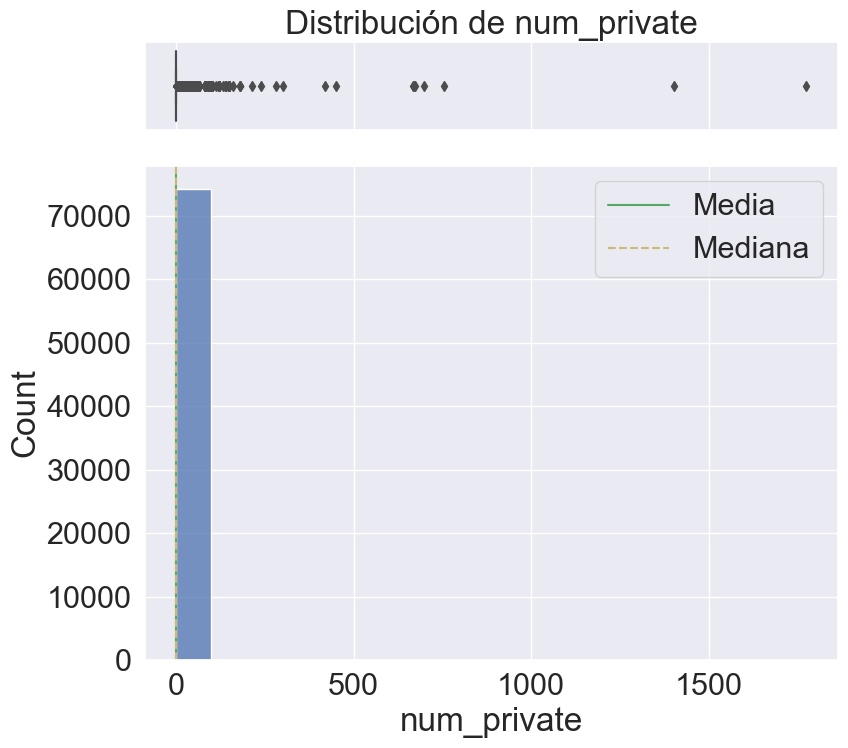

In [278]:
plot(full_df['num_private'])

Al analizar el poder predictivo de los valores teniendo en cuenta las distribuciones, parace que los valores perdidos tienen poder predictivo.

In [280]:
# Proporci√≥n valores 0
proporcion_invalidos = ((full_df['num_private'] == 0)).mean()
print(f"Proporci√≥n de valores fuera del rango en num_private: {proporcion_invalidos:.2%}")

Proporci√≥n de valores fuera del rango en num_private: 98.72%


In [281]:
# Filtrar solo registros donde != 0
subset = full_df[full_df['num_private'] != 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de num_private
print('valores por categor√≠a de status_group donde num_private != 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde num_private != 0


status_group
functional                 0.608983
functional needs repair    0.063408
non functional             0.327609
Name: proportion, dtype: float64

In [282]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

Conclusiones de `num_private`:

- Eliminaci√≥n de outliers y registros inv√°lidos
    - Modelo Actual:
        - Crear una variable tramificada de 0 o >0 
        - Descartar variable original
    - Modelos Siguientes:
        - Mantener si es importante, sino dscartar


- Feature Engineering
    - Modelo Actual:
        - Crear una variable tramificada de 0 o >0 
    - Modelos Futuros:
        - Mantener si es importante, sino dscartar

---

6 .`population`  
Hip√≥tesis: casi el 50% de los pozos tienen 0 de poblaci√≥n, pero hay un m√°ximo de `30,500`, lo que sugiere outliers severos.

Hay un porcentaje alto de 0, que suman 36%. Podrian pasarse a NaN sin problema. Tambien se observan varios outliers, pero hayq ue chequear que pasa si se pasan los valores 0 a NaN.

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



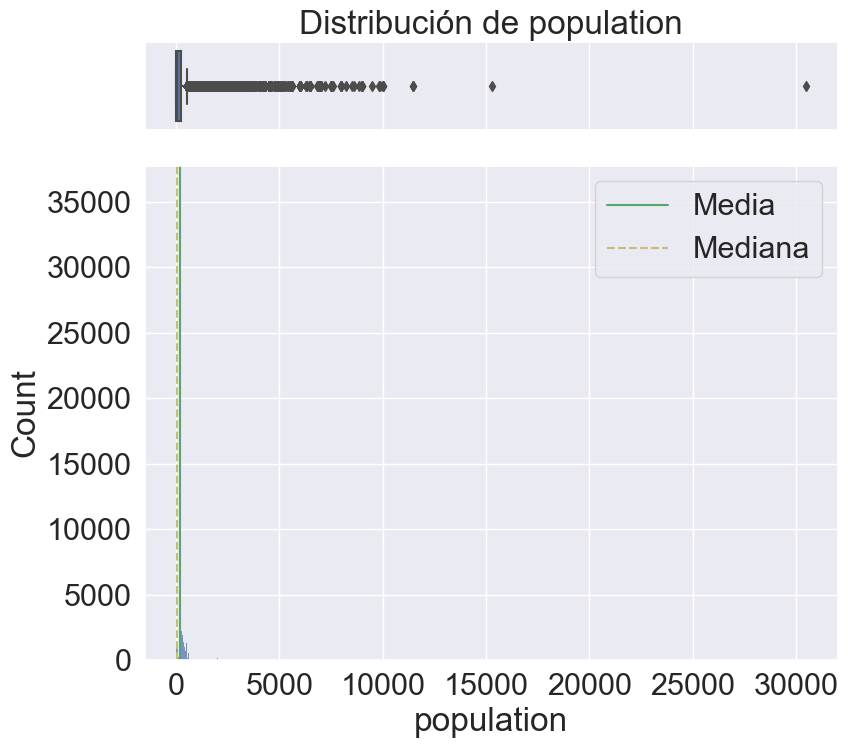

In [287]:
plot(full_df['population'])

In [288]:
# Proporci√≥n valores 0
proporcion_invalidos = ((full_df['population'] == 0)).mean()
print(f"Proporci√≥n de valores fuera del rango en num_private: {proporcion_invalidos:.2%}")

Proporci√≥n de valores fuera del rango en num_private: 36.14%


El porcentaje de outliers una vez removidos los ceros no ser√°mayor al %3, por lo que no ser√° un problema eliminarlos. Al ver la relaci√≥n de la proporcion de las categor√≠as de la variable objetivo para los tramos ==0 y >0, y al compararlas con el balance general de categor√≠as, se ve que ningun tramo parece tener poder predictivo especial para ninguna clase. Se recomienda evaluar el feature importance para ver si se mantiene o se descarta la variable.

In [290]:
# Evaluar la proporci√≥n de outliers sin modificar el DataFrame
columna = full_df['population'][full_df['population'] > 0].copy()
porc_inf, porc_sup, porc_total = gestiona_outliers(columna, clas='check')

# Mostrar resultados
print(f"Proporci√≥n de outliers por debajo: {porc_inf:.2f}%")
print(f"Proporci√≥n de outliers por encima: {porc_sup:.2f}%")
print(f"Proporci√≥n total de outliers: {porc_total:.2f}%")

population
Proporci√≥n de outliers por debajo: 0.00%
Proporci√≥n de outliers por encima: 3.01%
Proporci√≥n total de outliers: 3.01%


In [291]:
# Filtrar solo registros donde > 0
subset = full_df[full_df['population'] > 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de num_private
print('valores por categor√≠a de status_group donde num_private != 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde num_private != 0


status_group
functional                 0.551961
functional needs repair    0.066861
non functional             0.381178
Name: proportion, dtype: float64

In [292]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [293]:
# Filtrar solo registros donde == 0
subset = full_df[full_df['population'] == 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de num_private
print('valores por categor√≠a de status_group donde num_private != 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde num_private != 0


status_group
functional                 0.527291
functional needs repair    0.083018
non functional             0.389692
Name: proportion, dtype: float64

Conclusiones de `population`
- Eliminaci√≥n de outliers y registros inv√°lidos
    - Modelo Actual:
        - Convertir 0 a Nan
        - Winsorizar outliers
        - No imputar y dejar que el Random Forest capte los patrones de los valores perdidos
        - Verificar importancia de la variable para saber si se mantiene o no
    - Modelos Siguientes:
        - Buena candidata a descartarse. Mantener si es importante, sino descartar

- Feature Engineering
    - Modelo Actual:
        - No se recomienda nada
    - Modelos Futuros:
        - Mantener si es importante, sino dscartar


---

7. `construction_year`  
Hip√≥tesis: el valor 0 representa un missing no declarado. El resto de los valores parece estar en un rango razonable (`1960‚Äì2013`).  

Se concluye que los ceros son valores perdidos pero todos los dem√°s parecen ser a√±os v√°lidos. Adem√°s la distribuci√≥n de los a√±os excluyendo los 0, muestra un rango de a√±os sin outliers y un peque√±o sesgo a la izquierda.

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



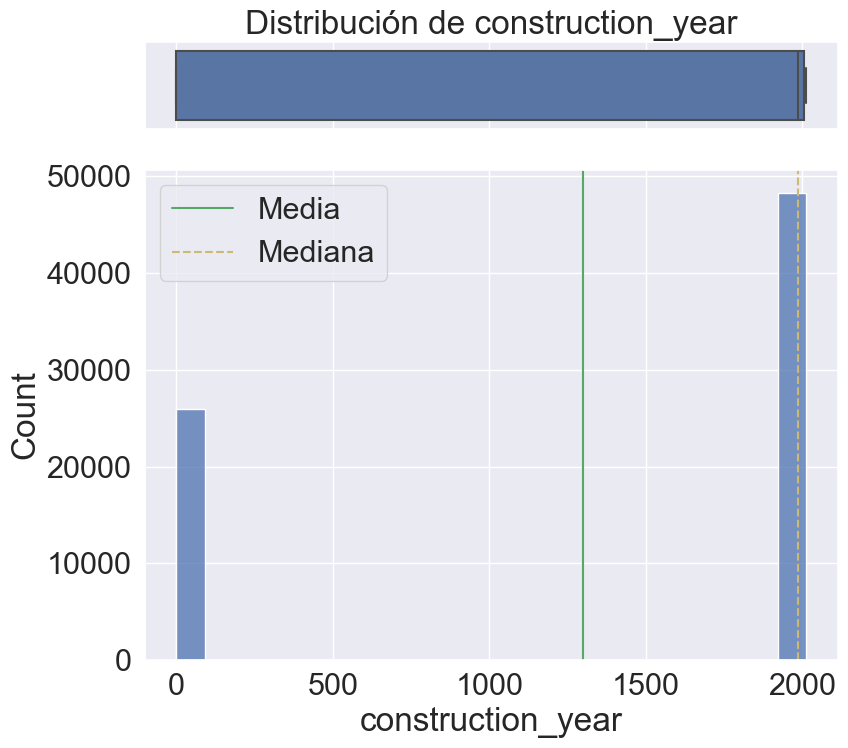

In [298]:
plot(full_df['construction_year'])

C:\Users\diabl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



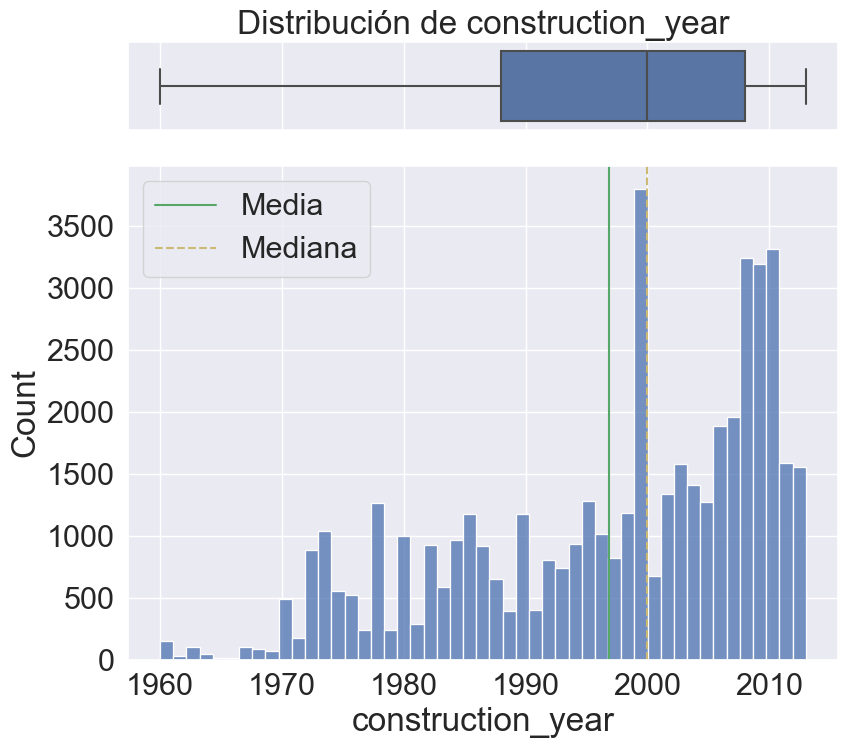

In [299]:
plot(full_df['construction_year'][full_df['construction_year'] != 0])

In [300]:
# Proporci√≥n valores 0
proporcion_invalidos = ((full_df['construction_year'] == 0)).mean()
print(f"Proporci√≥n de valores fuera del rango en num_private: {proporcion_invalidos:.2%}")

Proporci√≥n de valores fuera del rango en num_private: 34.98%


In [301]:
# Evaluar la proporci√≥n de outliers sin modificar el DataFrame
columna = full_df['construction_year'][full_df['construction_year'] > 0].copy()
porc_inf, porc_sup, porc_total = gestiona_outliers(columna, clas='check')

# Mostrar resultados
print(f"Proporci√≥n de outliers por debajo: {porc_inf:.2f}%")
print(f"Proporci√≥n de outliers por encima: {porc_sup:.2f}%")
print(f"Proporci√≥n total de outliers: {porc_total:.2f}%")

construction_year
Proporci√≥n de outliers por debajo: 0.00%
Proporci√≥n de outliers por encima: 0.00%
Proporci√≥n total de outliers: 0.00%


In [302]:
full_df['construction_year'][full_df['construction_year'] != 0].describe()

count    48281.000000
mean      1996.870943
std         12.440524
min       1960.000000
25%       1988.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

Los datos parecen no tener un valor predictivo para una clase espec√≠fica al calcular los porcentajes de ocurrencias

In [304]:
# Filtrar solo registros donde != 0
subset = full_df[full_df['construction_year'] != 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de num_private
print('valores por categor√≠a de status_group donde num_private != 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde num_private != 0


status_group
functional                 0.560957
functional needs repair    0.065338
non functional             0.373704
Name: proportion, dtype: float64

In [305]:
# Filtrar solo registros donde == 0
subset = full_df[full_df['construction_year'] == 0]

# Contar cu√°ntos valores de ese tipo hay por categor√≠a de num_private
print('valores por categor√≠a de status_group donde num_private != 0')
subset['status_group'].value_counts(normalize= True).sort_index()

valores por categor√≠a de status_group donde num_private != 0


status_group
functional                 0.509682
functional needs repair    0.086388
non functional             0.403931
Name: proportion, dtype: float64

In [306]:
full_df['status_group'].value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

Conclusiones de `construction_year`:
- Eliminaci√≥n outliers y registros inv√°lidos
    - Modelo Actual:
        - Reemplazar los 0 por `NaN` porque se comportan de manera indeterminada con respecto a la variable objetivo.
        - Winsorizar outliers
        - No imputar y ver que pasa en el Random Forest

    - Modelos Futuros:
        - Mantener solo si tiene importancia alta
        - Imputar missing con la mediana por distrito (district_code) o por region, para conservar patrones territoriales y ver si causa mejora


- Feature Engineering:
    - Modelos Futuros:
        - Crear una variable derivada 'years_old' que podria determinar mal funcionamiento
        - Hacer Binning por decadas y/o dos tramos si son o no edades menores de 20 a√±os

---

#### An√°lisis descriptivo General de variables categ√≥ricas

Al revisar las variables categ√≥ricas, y al leer la documentacion de los datos, se confirma que hay una relaci√≥n entre variables, donde hay unas variables que son derivadas de otras como:
- `extraction_type`:  The kind of extraction the waterpoint uses
- `extraction_type_group` The kind of extraction the waterpoint uses
- `extraction_type_class`: The kind of extraction the waterpoint uses

Esto es importante determinarlo para seleccionar la mejor variable de cada tipo en futuros modelos. Por esto se genera un diccionario de los grupos, llamado `grupos_variables`

In [311]:
grupos_variables = {
    "region": ["region", "region_code"],
    "extraction": ["extraction_type", "extraction_type_group", "extraction_type_class"],
    "payment": ["payment", "payment_type"],
    "water_quality": ["water_quality", "quality_group"],
    "quantity": ["quantity", "quantity_group"],
    "source": ["source", "source_type", "source_class"],
    "management": ["management", "management_group"],
    "waterpoint_type": ["waterpoint_type", "waterpoint_type_group"]
}

In [312]:
full_df.select_dtypes('category').head()

funder     installer              wpt_name                    basin  \
0         Roman         Roman                  none               Lake Nyasa   
1       Grumeti       GRUMETI              Zahanati            Lake Victoria   
2  Lottery Club  World vision           Kwa Mahundi                  Pangani   
3        Unicef        UNICEF  Zahanati Ya Nanyumbu  Ruvuma / Southern Coast   
4   Action In A       Artisan               Shuleni            Lake Victoria   

   subvillage   region region_code district_code        lga        ward  \
0    Mnyusi B   Iringa          11             5     Ludewa    Mundindi   
1     Nyamara     Mara          20             2  Serengeti       Natta   
2     Majengo  Manyara          21             4  Simanjiro     Ngorika   
3  Mahakamani   Mtwara          90            63   Nanyumbu    Nanyumbu   
4  Kyanyamisa   Kagera          18             1    Karagwe  Nyakasimbi   

  public_meeting              recorded_by scheme_management  \
0           True  GeoData Consultants Ltd               VWC   
1            NaN  GeoData Consultants Ltd             Other   
2           True  GeoData Consultants Ltd               VWC   
3           True  GeoData Consultants Ltd               VWC   
4           True  GeoData Consultants Ltd               NaN   

                   scheme_name permit extraction_type extraction_type_group  \
0                        Roman  False         gravity               gravity   
1                          NaN   True         gravity               gravity   
2  Nyumba ya mungu pipe scheme   True         gravity               gravity   
3                          NaN   True     submersible           submersible   
4                          NaN   True         gravity               gravity   

  extraction_type_class management management_group         payment  \
0               gravity        vwc       user-group    pay annually   
1               gravity        wug       user-group       never pay   
2               gravity        vwc       user-group  pay per bucket   
3           submersible        vwc       user-group       never pay   
4               gravity      other            other       never pay   

  payment_type water_quality quality_group      quantity quantity_group  \
0     annually          soft          good        enough         enough   
1    never pay          soft          good  insufficient   insufficient   
2   per bucket          soft          good        enough         enough   
3    never pay          soft          good           dry            dry   
4    never pay          soft          good      seasonal       seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    communal standpipe  non functional  
4           communal standpipe    communal standpipe      functional

In [313]:
# Seleccionar solo columnas categ√≥ricas
cat_cols = full_df.select_dtypes('category')

# Contar NaNs por columna
nulos = cat_cols.isna().sum()

# Contar cardinalidad (n√∫mero de categor√≠as √∫nicas) por columna
cardinalidad = cat_cols.nunique()

# Combinar en un solo DataFrame
resumen_cat = pd.DataFrame({
    'nulos': nulos,
    'cardinalidad': cardinalidad
}).sort_values(by='cardinalidad')

# Mostrar la tabla
resumen_cat

nulos  cardinalidad
recorded_by                0             1
public_meeting          4155             2
permit                  3793             2
status_group           14850             3
source_class               0             3
quantity_group             0             5
quantity                   0             5
management_group           0             5
quality_group              0             6
waterpoint_type_group      0             6
source_type                0             7
extraction_type_class      0             7
waterpoint_type            0             7
payment                    0             7
payment_type               0             7
water_quality              0             8
basin                      0             9
source                     0            10
scheme_management       4847            11
management                 0            12
extraction_type_group      0            13
extraction_type            0            18
district_code              0            20
region                     0            21
region_code                0            27
lga                        0           125
ward                       0          2098
funder                  4507          2139
installer               4532          2410
scheme_name            36052          2867
subvillage               470         21425
wpt_name                   2         45683

In [314]:
cat_cols.nunique().sort_values()

recorded_by                  1
public_meeting               2
permit                       2
status_group                 3
source_class                 3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
source_type                  7
extraction_type_class        7
waterpoint_type              7
payment                      7
payment_type                 7
water_quality                8
basin                        9
source                      10
scheme_management           11
management                  12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
lga                        125
ward                      2098
funder                    2139
installer                 2410
scheme_name               2867
subvillage               21425
wpt_name                 45683
dtype: i

Analizamos la relaci√≥n entre region y region_code y vemos que se trata de la misma variable, por lo que dejamos solo la de mayor cardinalidad `region_code`

In [316]:
# Funci√≥n para calcular Cram√©r's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correcci√≥n por sesgo
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Funci√≥n principal para an√°lisis
def analizar_columnas_categoricas(df, lista_pares):
    for col1, col2 in lista_pares:
        print(f"\nüîç Analizando relaci√≥n entre '{col1}' y '{col2}'")

        # 1. Cram√©r's V
        cv = cramers_v(df[col1], df[col2])
        print(f"üìè Cram√©r's V: {cv:.3f}")

        # 2. Crosstab normalizado por filas
        tabla = pd.crosstab(df[col1], df[col2], normalize='index')
        print("\nüìä Distribuci√≥n cruzada normalizada:")
        display(tabla)

        # 3. Diagrama de mosaico interactivo con Plotly ordenado por cardinalidad
        cardinalidad1 = df[col1].nunique()
        cardinalidad2 = df[col2].nunique()
        if cardinalidad1 <= cardinalidad2:
            path = [col1, col2]
        else:
            path = [col2, col1]

        # 4. Crear treemap interactivo
        df_temp = df[[col1, col2]].dropna()
        df_agg = df_temp.value_counts().reset_index()
        df_agg.columns = [col1, col2, 'count']

        fig = px.treemap(df_agg,
                         path=path,
                         values='count',
                         title=f'üß© Mosaico interactivo ordenado por cardinalidad: {path[0]} ‚ûù {path[1]}')

        fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
        fig.show(renderer='iframe')

In [317]:
analizar_columnas_categoricas(full_df, [('region', 'region_code')])


üîç Analizando relaci√≥n entre 'region' y 'region_code'
üìè Cram√©r's V: 0.998

üìä Distribuci√≥n cruzada normalizada:


region_code      1         2    3         4         5         6    7  \
region                                                                 
Arusha         0.0  0.902214  0.0  0.000000  0.000000  0.000000  0.0   
Dar es Salaam  0.0  0.000000  0.0  0.000000  0.000000  0.000000  1.0   
Dodoma         1.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Iringa         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Kagera         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Kigoma         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Kilimanjaro    0.0  0.000000  1.0  0.000000  0.000000  0.000000  0.0   
Lindi          0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Manyara        0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Mara           0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Mbeya          0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Morogoro       0.0  0.000000  0.0  0.000000  1.000000  0.000000  0.0   
Mtwara         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Mwanza         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Pwani          0.0  0.000000  0.0  0.000000  0.000000  0.610027  0.0   
Rukwa          0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Ruvuma         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Shinyanga      0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Singida        0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Tabora         0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
Tanga          0.0  0.000000  0.0  0.987131  0.012869  0.000000  0.0   

region_code           8         9   10       11        12   13        14   15  \
region                                                                          
Arusha         0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Dar es Salaam  0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Dodoma         0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Iringa         0.000000  0.000000  0.0  1.00000  0.000000  0.0  0.000000  0.0   
Kagera         0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Kigoma         0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Kilimanjaro    0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Lindi          0.195312  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Manyara        0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Mara           0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Mbeya          0.000000  0.000000  0.0  0.00000  1.000000  0.0  0.000000  0.0   
Morogoro       0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Mtwara         0.000000  0.232743  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Mwanza         0.000000  0.000000  0.0  0.00000  0.000257  0.0  0.000000  0.0   
Pwani          0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   
Rukwa          0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  1.0   
Ruvuma         0.000000  0.000000  1.0  0.00000  0.000000  0.0  0.000000  0.0   
Shinyanga      0.000000  0.000000  0.0  0.00143  0.000000  0.0  0.003496  0.0   
Singida        0.000000  0.000000  0.0  0.00000  0.000000  1.0  0.000000  0.0   
Tabora         0.000000  0.000000  0.0  0.00000  0.000000  0.0  1.000000  0.0   
Tanga          0.000000  0.000000  0.0  0.00000  0.000000  0.0  0.000000  0.0   

region_code     16        17        18        19   20   21        24      40  \
region                                                                         
Arusha         0.0  0.000000  0.000000  0.000000  0.0  0.0  0.097786  0.0000   
Dar es Salaam  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0000   
Dodoma         0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0000   
Iringa         0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0000   

C:\Users\diabl\anaconda3\Lib\site-packages\plotly\express\_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\diabl\anaconda3\Lib\site-packages\plotly\express\_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [318]:
full_df = full_df.drop('region', axis=1)

Observando las caracter√≠sticas generales de los datos, se ha organizado el procesamiento de las variables categ√≥ricas en 4 grupos, basados en su cardinalidad (n√∫mero de categor√≠as distintas) y la presencia de valores nulos. Esta clasificaci√≥n permite un tratamiento m√°s r√°pido y consistente con la tolerancia que tienen los modelos de √°rbol hacia variables categ√≥ricas codificadas como enteros.

Grupo 1: Baja cardinalidad (‚â§ 10 categor√≠as)  
Ejemplos: `quantity`, `quality_group`, `water_quality`, `payment_type`, `basin`, `waterpoint_type`

- **Acci√≥n (modelo actual)**:
  - Codificaci√≥n como enteros mediante `astype('category').cat.codes` o `OrdinalEncoder` si se desea usar dentro de un pipeline.
  - No se imputan valores nulos.
  - Se conserva cualquier categor√≠a tipo `'unknown'` u `'other'` como est√°.

- **Futuros modelos**:
  - Se puede probar agrupar categor√≠as infrecuentes si se detecta ruido.
  - Imputar los nulos si se utiliza un modelo que no los tolere.

Grupo 2: Cardinalidad media (entre 11 y 27 categor√≠as)  
Ejemplos: `management`, `extraction_type`, `extraction_type_group`, `district_code`, `region_code`

- **Acci√≥n (modelo actual)**:
  - Codificaci√≥n como enteros sin imputaci√≥n de nulos.
  - Se permite que el modelo trate clases poco frecuentes como ramas menos informativas.

- **Futuros modelos**:
  - Posible agrupaci√≥n de categor√≠as poco frecuentes.
  - Imputaci√≥n de nulos si es requerido por el modelo.

Grupo 3: Alta cardinalidad (> 27 categor√≠as, sin nulos importantes)  
Ejemplos: `lga`, `ward`

- **Acci√≥n (modelo actual)**:
  - Codificaci√≥n como enteros.
  - No se imputan valores nulos (si no existen).
  - Se recomienda monitorear la importancia de estas variables para evitar ruido.

- **Futuros modelos**:
  - Considerar reducci√≥n de cardinalidad (e.g., agrupar categor√≠as poco frecuentes).
  - Posiblemente reemplazar con clustering sem√°ntico o variables derivadas si generan overfitting.

Grupo 4: Alta cardinalidad con muchos nulos  
Ejemplos: `funder`, `installer`, `scheme_management`, `scheme_name`, `subvillage`, `wpt_name`

- **Acci√≥n (modelo actual)**:
  - No imputar valores nulos.
  - Aplicar codificaci√≥n como enteros (`cat.codes`) conservando los `NaN`.
  - Se recomienda acompa√±ar de un an√°lisis posterior de importancia para decidir si conservar.

- **Futuros modelos**:
  - No reemplazar `NaN` por `'unknown'`, ya que se ha observado que estos casos se comportan de manera distinta.
  - Posible uso de codificaci√≥n por frecuencia si hay relaci√≥n con el target.
  - Agrupaci√≥n de categor√≠as por similitud (KNN, clustering) si se cuenta con recursos y tiempo.


**Importante**: Esta codificaci√≥n est√° optimizada para modelos como **Random Forest** o **XGBoost**, que pueden manejar variables categ√≥ricas codificadas como enteros (aunque no tengan un orden l√≥gico) y **toleran valores `NaN` sin necesidad de imputarlos**.

No es adecuada para modelos lineales o redes neuronales, ya que:

- Los enteros pueden inducir un orden artificial entre categor√≠as si no hay un orden real.
- Los valores `NaN` no son interpretables y deben ser imputados expl√≠citamente.
- Las variables con alta cardinalidad pueden causar overfitting o sparsity si no se agrupan o transforman.

Para estos modelos se recomienda aplicar **One-Hot Encoding**, **embeddings categ√≥ricos**, o **t√©cnicas de reducci√≥n de cardinalidad**, junto con un tratamiento expl√≠cito de valores nulos.


Con esta informaci√≥n se genera un diccionario de variables llamado `grupos_prepocesamiento_categoricas`.

In [320]:
grupos_prepocesamiento_categoricas = {
    "grupo_1_baja_cardinalidad": [  # ‚â§ 10 categor√≠as, sin nulos importantes
        'recorded_by', 'public_meeting', 'permit', 'status_group',
        'source_class', 'quantity_group', 'quantity', 'management_group',
        'quality_group', 'waterpoint_type_group', 'source_type',
        'waterpoint_type', 'payment_type', 'extraction_type_class',
        'payment', 'water_quality', 'basin', 'source'
    ],
    
    "grupo_2_cardinalidad_media": [  # 11‚Äì27 categor√≠as
        'scheme_management', 'management', 'extraction_type_group',
        'extraction_type', 'district_code', 'region_code'
    ],
    
    "grupo_3_alta_cardinalidad": [  # > 27 categor√≠as, sin nulos importantes
        'lga', 'ward'
    ],
    
    "grupo_4_alta_card_con_nulos": [  # > 27 categor√≠as con muchos nulos
        'funder', 'installer', 'scheme_name', 'subvillage', 'wpt_name'
    ]
}

Se genera un informe a ver si hay variables derivadas de un mismo tipo en grupos problematicos para as√≠ descartarlas. No se encuentra nada. 

In [322]:
from collections import defaultdict
import pandas as pd

# Diccionario resultado para guardar en qu√© grupo de preprocesamiento est√° cada variable
ubicacion_variables = {}

# Invertimos el diccionario de preprocesamiento: cada variable ‚Üí su grupo
for grupo, variables in grupos_prepocesamiento_categoricas.items():
    for var in variables:
        ubicacion_variables[var] = grupo

# Analizamos los grupos conceptuales
reporte_separacion = []

for grupo_conceptual, variables in grupos_variables.items():
    grupos_detectados = defaultdict(list)
    
    for var in variables:
        grupo_prep = ubicacion_variables.get(var, "NO CLASIFICADO")
        grupos_detectados[grupo_prep].append(var)

    if len(grupos_detectados) > 1:
        reporte_separacion.append({
            "grupo_conceptual": grupo_conceptual,
            "distribucion_grupos_prep": dict(grupos_detectados)
        })

# Mostrar el reporte
reporte_df = pd.DataFrame(reporte_separacion)
pd.set_option('display.max_colwidth', None)  # Para ver todo el texto
reporte_df

grupo_conceptual  \
0           region   
1       extraction   
2       management   

                                                                                                               distribucion_grupos_prep  
0                                                         {'NO CLASIFICADO': ['region'], 'grupo_2_cardinalidad_media': ['region_code']}  
1  {'grupo_2_cardinalidad_media': ['extraction_type', 'extraction_type_group'], 'grupo_1_baja_cardinalidad': ['extraction_type_class']}  
2                                     {'grupo_2_cardinalidad_media': ['management'], 'grupo_1_baja_cardinalidad': ['management_group']}

---

#### EDA de cada variable categ√≥rica para determinar missings no declarados y posibles formas de imputaci√≥n y gesti√≥n de outliers

En honor al tiempo, en este modelo no se hace este proceso

---

In [327]:
# Obtener lista de columnas v√°lidas del grupo 1
grupo_1 = grupos_prepocesamiento_categoricas["grupo_1_baja_cardinalidad"]

# Filtrar solo las columnas categ√≥ricas presentes en el DataFrame
grupo_1_validas = [
    col for col in grupo_1 
    if col in full_df.columns and str(full_df[col].dtype) == 'category'
]

# Aplicar codificaci√≥n con .cat.codes sin imputar nulos
for col in grupo_1_validas:
    full_df[col] = full_df[col].cat.codes.replace(-1, np.nan)

### 1.3) Eliminaci√≥n de outliers, registros inv√°lidos e imputaci√≥n

Como vimos, para las variables categ√≥ricas no se va a eliminar registros inv√°lidos. Para las variables num√©ricas, s√≠. Por esto recogemos las conclusiones del EDA:

Reporte de limpieza para variables num√©ricas

---

`amount_tsh`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Reemplazar los valores `0` por `NaN` (se comportan de forma ambigua respecto al target).
  - Winsorizar valores extremos (outliers ‚âà 6.24%).
  - Evaluar si la variable debe conservarse por la cantidad de valores faltantes.
  - Imputar usando la **mediana por distrito** o **regi√≥n**, para mantener coherencia geogr√°fica.

- **Modelos futuros**:
  - Tratar outliers como `NaN` directamente.
  - Imputar nuevamente con mediana regional o distrital.

**Feature Engineering**

- Crear variable booleana auxiliar: `amount_tsh == 0`.
- Aplicar transformaci√≥n logar√≠tmica `log(1 + x)` para suavizar la distribuci√≥n.

---

`gps_height`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Tratar todos los valores `‚â§ 0` como *missing no declarado* (`NaN`).
  - No se detectan outliers significativos.
  - Imputar por **mediana regional o distrital**.

- **Modelos futuros**:
  - Misma estrategia: convertir valores dudosos en `NaN`.
  - Imputar con mediana por regi√≥n/distrito.

**Feature Engineering**

- Aplicar transformaci√≥n `log(1 + x)` si se observa sesgo en la distribuci√≥n.

---

`longitude`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Reemplazar valores fuera del rango `[29.20, 40.45]` con `NaN`.
  - Crear bandera `coord_invalida` para marcar coordenadas inv√°lidas (3.06%).
  - No se requieren transformaciones adicionales (no hay outliers claros).

- **Modelos futuros**:
  - Imputar coordenadas inv√°lidas con valor simb√≥lico (e.g. `-999`), mantener el flag `coord_invalida`.
  - O eliminar la variable si se reemplaza por clusters espaciales o distancias.

**Feature Engineering**

- `coord_invalida` como variable predictiva.
- Crear `geo_cluster`, `dist_to_capital`, y otros derivados solo para registros v√°lidos.

---

`latitude`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Reemplazar valores fuera de `[-11.75, -0.98]` con `NaN`.
  - Crear bandera `coord_invalida` (proporci√≥n similar a `longitude`).
  - No imputar valores faltantes en modelos basados en √°rboles.

- **Modelos futuros**:
  - Imputar con valores simb√≥licos fuera de rango (`-999`) si es necesario.
  - O reemplazar por variables espaciales derivadas.

**Feature Engineering**

- Igual que en `longitude`: `coord_invalida`, `geo_cluster`, `dist_to_capital`, etc.

---

`num_private`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - El 98% son ceros ‚Üí codificar como variable binaria (`0` vs `>0`).
  - Eliminar variable original si se confirma irrelevancia.

- **Modelos futuros**:
  - Mantener solo si muestra importancia predictiva.

**Feature Engineering**

- Variable binaria: `tiene_num_private = (num_private > 0).astype(int)`

---

`population`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Reemplazar `population == 0` por `NaN` (36% del total).
  - Winsorizar valores extremos (outliers ‚âà 3%).
  - No imputar por ahora, dejar que el modelo maneje los `NaN`.

- **Modelos futuros**:
  - Candidata a ser eliminada si no aporta al modelo.

**Feature Engineering**

- No se propone ingenier√≠a espec√≠fica para esta variable.

---

`construction_year`

**Eliminaci√≥n de outliers y registros inv√°lidos**

- **Modelo actual**:
  - Tratar `construction_year == 0` como *missing no declarado* (`NaN`).
  - No hay outliers reales (todos los valores v√°lidos est√°n entre 1960‚Äì2013).

- **Modelos futuros**:
  - Imputar por **mediana distrital o regional**.
  - Mantener si muestra importancia relevante.

**Feature Engineering**

- Variable derivada: `years_old = year_recorded - construction_year`.
- Binning por d√©cadas o grupo dicot√≥mico (e.g., m√°s o menos de 20 a√±os de antig√ºedad).

Generamos un pipeline que incluya todo eso

In [331]:
# Copiar el DataFrame original
full_df_clean_num = full_df.copy()

# ----------------------------------------
# 1. amount_tsh
# ----------------------------------------
# Reemplazar 0 por NaN
full_df_clean_num['amount_tsh'] = full_df_clean_num['amount_tsh'].replace(0, np.nan)

# Winsorizar outliers (p. ej., al percentil 99)
q_hi = full_df_clean_num['amount_tsh'].quantile(0.99)
full_df_clean_num['amount_tsh'] = np.where(
    full_df_clean_num['amount_tsh'] > q_hi,
    q_hi,
    full_df_clean_num['amount_tsh']
)

# ----------------------------------------
# 2. gps_height
# ----------------------------------------
# Tratar valores <= 0 como NaN
full_df_clean_num['gps_height'] = full_df_clean_num['gps_height'].mask(full_df_clean_num['gps_height'] <= 0, np.nan)

# ----------------------------------------
# 3. longitude
# ----------------------------------------
# Crear bandera de coordenadas inv√°lidas
full_df_clean_num['coord_invalida'] = ~full_df_clean_num['longitude'].between(29.20, 40.45) | ~full_df_clean_num['latitude'].between(-11.75, -0.98)

# Reemplazar longitudes fuera de rango por NaN
full_df_clean_num['longitude'] = full_df_clean_num['longitude'].mask(~full_df_clean_num['longitude'].between(29.20, 40.45), np.nan)

# ----------------------------------------
# 4. latitude
# ----------------------------------------
# Reemplazar latitudes fuera de rango por NaN
full_df_clean_num['latitude'] = full_df_clean_num['latitude'].mask(~full_df_clean_num['latitude'].between(-11.75, -0.98), np.nan)

# ----------------------------------------
# 5. num_private
# ----------------------------------------
# Crear variable binaria auxiliar
full_df_clean_num['num_private_bin'] = (full_df_clean_num['num_private'] > 0).astype(int)

# ----------------------------------------
# 6. population
# ----------------------------------------
# Reemplazar valores 0 por NaN
full_df_clean_num['population'] = full_df_clean_num['population'].replace(0, np.nan)

# Winsorizar al percentil 99
q_hi_pop = full_df_clean_num['population'].quantile(0.99)
full_df_clean_num['population'] = np.where(
    full_df_clean_num['population'] > q_hi_pop,
    q_hi_pop,
    full_df_clean_num['population']
)

# ----------------------------------------
# 7. construction_year
# ----------------------------------------
# Tratar valores 0 como NaN
full_df_clean_num['construction_year'] = full_df_clean_num['construction_year'].replace(0, np.nan)

# Crear variable derivada: antig√ºedad del pozo
full_df_clean_num['years_old'] = pd.to_datetime(full_df_clean_num['date_recorded']).dt.year - full_df_clean_num['construction_year']
full_df_clean_num['years_old'] = full_df_clean_num['years_old'].mask(full_df_clean_num['construction_year'].isna(), np.nan)

En este caso no se limpian las variables categoricas por lo que podemos tener un solo data frame clean igual al de las numericas

In [333]:
full_df_clean = full_df_clean_num.copy()

### 1.4) Feature Engineering

Trabajamos sobre una copia del dataFrame

In [336]:
full_df_clean_fe = full_df_clean.copy()

Feature Engineering para variables num√©ricas `longitude` y `latitude`:

- Clustering espacial (geo_cluster) sobre coordenadas v√°lidas.
- C√°lculo de distancia a un punto de referencia (dist_to_capital), solo para registros v√°lidos.
- C√°lculo de n√∫mero o proporci√≥n de vecinos no funcionales (BallTree), excluyendo coordenadas inv√°lidas.

In [338]:
# üí° Feature Engineering: Variables num√©ricas
# ------------------------------------------------------

# 1. Clustering espacial sobre coordenadas v√°lidas
coord_validas = full_df_clean_fe[~full_df_clean_fe['coord_invalida']][['latitude', 'longitude']]
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(coord_validas)

full_df_clean_fe['geo_cluster'] = np.nan
full_df_clean_fe.loc[~full_df_clean_fe['coord_invalida'], 'geo_cluster'] = clusters
full_df_clean_fe['geo_cluster'] = full_df_clean_fe['geo_cluster'].astype('Int64')  # permite nulos

# 2. Distancia a la capital (Dodoma)
capital_coords = (-6.1630, 35.7516)
def calcular_distancia(row):
    if not row['coord_invalida']:
        return geodesic((row['latitude'], row['longitude']), capital_coords).km
    else:
        return np.nan

full_df_clean_fe['dist_to_capital'] = full_df_clean_fe.apply(calcular_distancia, axis=1)

# 3. N√∫mero de vecinos no funcionales en un radio de 10 km
valid_coords = full_df_clean_fe.loc[~full_df_clean_fe['coord_invalida'], ['latitude', 'longitude']].dropna()
valid_coords_rad = np.radians(valid_coords.astype(float).values)

tree = BallTree(valid_coords_rad, metric='haversine')
r = 10 / 6371  # 10 km en radianes

valid_indices = full_df_clean_fe[~full_df_clean_fe['coord_invalida']].index
status = full_df_clean_fe.loc[valid_indices, 'status_group'].reset_index(drop=True)

vecinos_no_func = []
for i, coord in enumerate(valid_coords_rad):
    idx_vecinos = tree.query_radius([coord], r)[0]
    if len(idx_vecinos) <= 1:
        vecinos_no_func.append(0)
    else:
        vecinos_status = status.iloc[idx_vecinos]
        count = (vecinos_status == 'non functional').sum() - (status.iloc[i] == 'non functional')
        vecinos_no_func.append(count)

full_df_clean_fe['non_func_neighbors_10km'] = np.nan
full_df_clean_fe.loc[valid_indices, 'non_func_neighbors_10km'] = vecinos_no_func

Para variables categ√≥ricas no se realiza un Feature engineering, pero en las conclusiones del EDA se mencionan algunas ideas para modelos posteriores

---

### 1.5) Codificaci√≥n de variables categ√≥ricas

Se aplicara una codificaci√≥n r√°pida y compatible con modelos de √°rbol (Random Forest) sin imputar valores nulos ni agrupar clases infrecuentes. La estrategia se basa en los 4 grupos definidos por cardinalidad y presencia de NaN.

**Grupo 1:** Baja cardinalidad (‚â§ 10 categor√≠as)
Codificaci√≥n: astype('category').cat.codes
Valores nulos: No se imputan.
Otras categor√≠as: Se mantiene 'unknown' o 'other' tal como aparecen.


**Grupo 2:** Cardinalidad media (11 a 27 categor√≠as)
Codificaci√≥n: astype('category').cat.codes
Valores nulos: No se imputan.
Notas: Se tolera la existencia de clases raras; el modelo aprender√° su relevancia.


**Grupo 3:** Alta cardinalidad (> 27 categor√≠as, sin nulos importantes)
Codificaci√≥n: astype('category').cat.codes
Valores nulos: No se imputan (si no hay).
Notas: No se agrupa ni reduce cardinalidad por ahora; se monitorea su importancia.


**Grupo 4:** Alta cardinalidad con muchos nulos
Codificaci√≥n: astype('category').cat.codes, conservando NaN (sin reemplazarlos).
Valores nulos: Se dejan como NaN, el modelo los manejar√° internamente.
Notas: No se usa 'unknown' como imputaci√≥n.

In [343]:
grupos_prepocesamiento_categoricas = {
    "grupo_1_baja_cardinalidad": [
        'recorded_by', 'public_meeting', 'permit', 'status_group',
        'source_class', 'quantity_group', 'quantity', 'management_group',
        'quality_group', 'waterpoint_type_group', 'source_type',
        'waterpoint_type', 'payment_type', 'extraction_type_class',
        'payment', 'water_quality', 'basin', 'source'
    ],
    "grupo_2_cardinalidad_media": [
        'scheme_management', 'management', 'extraction_type_group',
        'extraction_type', 'district_code', 'region_code'
    ],
    "grupo_3_alta_cardinalidad": [
        'lga', 'ward'
    ],
    "grupo_4_alta_card_con_nulos": [
        'funder', 'installer', 'scheme_name', 'subvillage', 'wpt_name'
    ]
}

for grupo, columnas in grupos_prepocesamiento_categoricas.items():
    for col in columnas:
        if col in full_df_clean_fe.columns:
            full_df_clean_fe[col] = full_df_clean_fe[col].astype('category').cat.codes.replace(-1, np.nan)

---

## 2) Modeling

### 2.1) Divisi√≥n train/validation estratificada

Creamos nuevos datasets desde full_df_clean_fe, eliminando las columnas auxiliares que ya no sirven (status_group, is_train) y columnas ya transformadas (latitude, longitude):

In [352]:
columnas_a_eliminar = ['status_group', 'is_train', 'latitude', 'longitude']

X_train_clean_fe = full_df_clean_fe[full_df_clean_fe['is_train']].drop(columns=columnas_a_eliminar)
X_test_clean_fe  = full_df_clean_fe[~full_df_clean_fe['is_train']].drop(columns=columnas_a_eliminar)
y_train_clean_fe = y_train.copy()

print("‚úÖ X_train_clean_fe shape:", X_train_clean_fe.shape)
print("‚úÖ y_train_clean_fe shape:", y_train_clean_fe.shape)

‚úÖ X_train_clean_fe shape: (59400, 43)
‚úÖ y_train_clean_fe shape: (59400, 2)


### 2.2) Entrenamiento de modelos base

Entrenamos un Random Forest preliminar. Vemos que se imputa -999 a las variables categoricas y se recuerda que en el pipeline de codificaci√≥n de variables categ√≥ricas ya se imputo los NaN por -1. Notese adem√°s que para este modelo se excluye los datos de X_test, porque esos no tienen datos correspondientes de y_test

In [355]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

# ‚úÖ Correcci√≥n: usar solo la columna objetivo
y_train_rf = y_train_clean_fe['status_group']

# üìã Preparar copias
X_train_rf = X_train_clean_fe.copy().drop(columns=['date_recorded'])
X_test_rf  = X_test_clean_fe.copy().drop(columns=['date_recorded'])

# üßº Imputaci√≥n simb√≥lica para NaNs
X_train_rf = X_train_rf.fillna(-999)
X_test_rf  = X_test_rf.fillna(-999)

# ‚úÇÔ∏è Divisi√≥n 80-20 estratificada
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_rf,
    y_train_rf,
    test_size=0.2,
    stratify=y_train_rf,
    random_state=42
)

# üå≥ Entrenar modelo base
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_base, y_train_base)

# üß™ Evaluaci√≥n sobre el 20% de validaci√≥n
y_pred_base = rf.predict(X_val_base)
f1_macro = f1_score(y_val_base, y_pred_base, average='macro')

print("‚úÖ F1 Macro en conjunto de validaci√≥n (20%):", f1_macro)
print("\nüìã Reporte de clasificaci√≥n:")
print(classification_report(y_val_base, y_pred_base))

C:\Users\diabl\AppData\Local\Temp\ipykernel_27740\1193142032.py:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\diabl\AppData\Local\Temp\ipykernel_27740\1193142032.py:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



‚úÖ F1 Macro en conjunto de validaci√≥n (20%): 0.68084428016234

üìã Reporte de clasificaci√≥n:
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.57      0.29      0.39       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



### 2.3) Ajuste de hiperpar√°metros

Definimos un set de datos tentaivos para ver que funciona mejor. Posteriormente se puede hilar fino en los intervalos. Se ejecuta un tunning con CV de 5 folds.

In [438]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# Espacio de b√∫squeda de hiperpar√°metros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']  # Para intentar mejorar recall en clases minoritarias
}

# Definir modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Definir validaci√≥n cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar b√∫squeda aleatoria
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Puedes aumentar si tienes tiempo
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ejecutar b√∫squeda
random_search.fit(X_train_base, y_train_base)

# Resultados
print("üéØ Mejor combinaci√≥n de hiperpar√°metros:")
print(random_search.best_params_)
print("üìä Mejor F1 Macro obtenido:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
üéØ Mejor combinaci√≥n de hiperpar√°metros:
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 157}
üìä Mejor F1 Macro obtenido: 0.6959746049243847


### 2.4) Evaluaci√≥n con m√©tricas

Comprobamos el desempe√±o del mejor modelo en base a los par√°metros elegidos. Vemos que el modelo ajustado mejor√≥ el F1 Macro a casi 0.70, especialmente en la clase minoritaria functional needs repair, que pas√≥ de 0.39 ‚Üí 0.45 gracias al uso de class_weight='balanced'.
Mantiene alto rendimiento en las otras clases y logra un balance mucho mejor entre precisi√≥n y cobertura.

‚úÖ F1 Macro en conjunto de validaci√≥n (modelo ajustado): 0.6996079536622691

üìã Reporte de clasificaci√≥n:
                         precision    recall  f1-score   support

             functional       0.83      0.83      0.83      6452
functional needs repair       0.39      0.54      0.45       863
         non functional       0.85      0.78      0.82      4565

               accuracy                           0.79     11880
              macro avg       0.69      0.72      0.70     11880
           weighted avg       0.80      0.79      0.80     11880



C:\Users\diabl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.



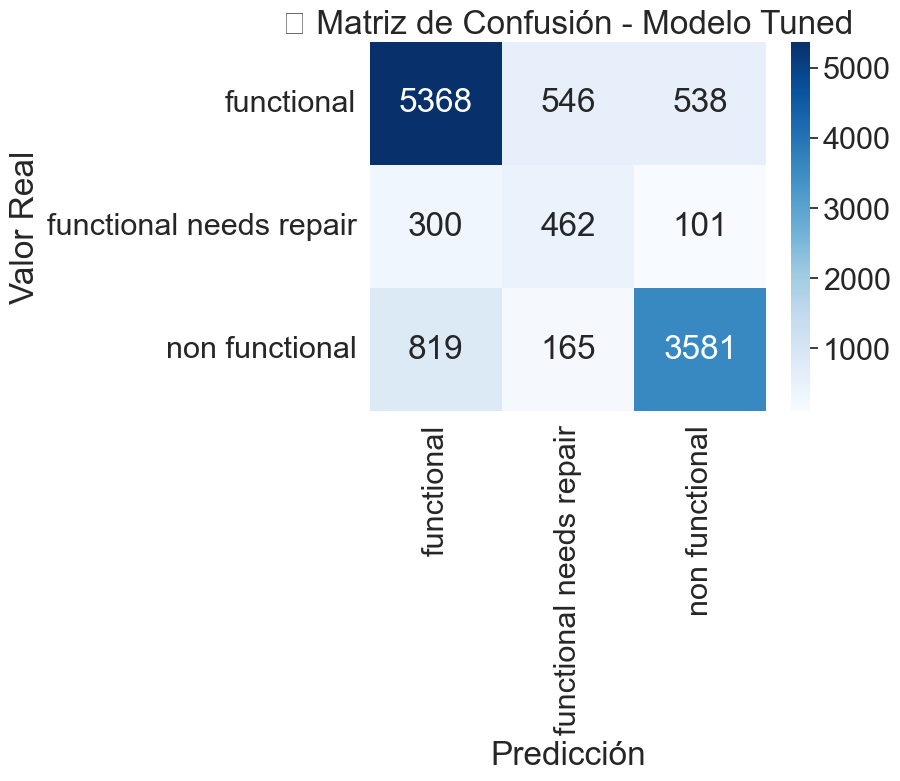

In [445]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener mejor modelo
best_rf = random_search.best_estimator_

# Predecir sobre el conjunto de validaci√≥n
y_pred_best = best_rf.predict(X_val_base)

# F1 Macro
f1_best = f1_score(y_val_base, y_pred_best, average='macro')
print("‚úÖ F1 Macro en conjunto de validaci√≥n (modelo ajustado):", f1_best)

# Reporte detallado
print("\nüìã Reporte de clasificaci√≥n:")
print(classification_report(y_val_base, y_pred_best))

# Matriz de confusi√≥n
conf_mat = confusion_matrix(y_val_base, y_pred_best, labels=best_rf.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("üîç Matriz de Confusi√≥n - Modelo Tuned")
plt.xlabel("Predicci√≥n")
plt.ylabel("Valor Real")
plt.show()


## 3) Deployment

#### 3.1) Entrenar el modelo final con todo el X_train_clean y y_train_clean

In [448]:
# Preparar datos finales para entrenamiento
X_deploy = X_train_clean_fe.copy().drop(columns=['date_recorded'])
X_deploy = X_deploy.fillna(-999)
y_deploy = y_train_clean_fe['status_group']

# Entrenar el mejor modelo con todos los datos disponibles
final_model = RandomForestClassifier(
    **random_search.best_params_,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_deploy, y_deploy)

C:\Users\diabl\AppData\Local\Temp\ipykernel_27740\3715298651.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       min_samples_split=13, n_estimators=157, n_jobs=-1,
                       random_state=42)

#### 3.2) Predecir sobre X_test_clean

In [450]:
# Preparar test para predicci√≥n
X_test_deploy = X_test_clean_fe.copy().drop(columns=['date_recorded'])
X_test_deploy = X_test_deploy.fillna(-999)

# Predecir
y_pred_test = final_model.predict(X_test_deploy)

C:\Users\diabl\AppData\Local\Temp\ipykernel_27740\771391458.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### Resultados en la plataforma Driven Data

Las predicciones generadas fueron evaluadas en la plataforma oficial de DrivenData. El modelo alcanz√≥ una calificaci√≥n de **F1-macro score = 0.8020**, confirmando su desempe√±o competitivo en un entorno de validaci√≥n externa.

<img src="../outputs/Captura de pantalla 2025-06-04 151704.png" alt="Mi imagen" width="600">

---

## 4) Conclusiones

El modelo desarrollado logr√≥ predecir con √©xito el estado operativo de bombas de agua en Tanzania, alcanzando un **F1-macro score de 0.8020**. Este resultado es consistente con los desaf√≠os inherentes al dataset, caracterizado por:
- Alto porcentaje de datos nulos e inconsistentes en variables cr√≠ticas como `construction_year` y `gps_height`.
- Variables categ√≥ricas de alta cardinalidad que requer√≠an estrategias de codificaci√≥n espec√≠ficas.
- Desbalance entre clases, con predominancia de bombas funcionales.

El an√°lisis de importancia de variables revel√≥ que factores como `quantity` (tipo de cantidad de agua disponible), `gps_height` (altitud), `longitude` (ubicaci√≥n geogr√°fica) y `population` (n√∫mero de personas dependientes) son determinantes en el estado funcional de las bombas.

**Aplicaci√≥n pr√°ctica**:
El modelo puede ser utilizado para anticipar fallos en el sistema de agua, priorizar mantenimientos y optimizar la asignaci√≥n de recursos en programas de infraestructura h√≠drica en zonas rurales, contribuyendo a mejorar el acceso sostenible al agua potable.

**Limitaciones**:
- El modelo depende de la calidad de los datos de entrada; variables como el a√±o de construcci√≥n siguen presentando alta proporci√≥n de datos faltantes.
- La predicci√≥n se realiza bajo el supuesto de que las condiciones ambientales y socioecon√≥micas son estables, lo cual podr√≠a no ser cierto en el tiempo.

**Recomendaciones**:
- Implementar t√©cnicas de balanceo como SMOTE para mejorar la predicci√≥n de clases minoritarias.
- Explorar algoritmos de boosting como LightGBM o CatBoost.
- Investigar la integraci√≥n de datos satelitales o clim√°ticos para enriquecer el conjunto de predictores.


---

---